In [1]:
import os
import logging
import argparse
import random
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
import numpy as np
from shutil import copyfile
import torch
from KEMCE.dag_bert import SeqsTokenizer, EntityTokenizer, DescTokenizer, \
    KemceForPreTraining, BertAdam, BertConfig
from KEMCE.dataset import prepare_data, BERTDataset, collate_mlm, LabelsForData
import collections
from KEMCE.utils import ConceptEvaluation
from GRAM.gram_helpers import build_tree_with_padding
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import torch
import heapq
import operator

In [2]:
data_path = '../'
data_dir = data_path + 'outputs/kemce/data/raw/'
seqs_file = data_path + 'outputs/kemce/data/raw/mimic_pre_train.seqs'
dict_file = data_path + 'outputs/kemce/data/raw/mimic_pre_train_vocab.txt'


sigle_dx_file = data_path + 'ccs/ccs_single_dx_tool_2015.csv'
multi_dx_file = data_path + 'ccs/ccs_multi_dx_tool_2015.csv'

In [3]:
label4data = LabelsForData(multi_dx_file, sigle_dx_file)

In [4]:
pretrained_dir = os.path.join(data_path, 'outputs/kemce/models/pre_train_dag1/')
weights_path = os.path.join(pretrained_dir, 'pytorch_model.bin')

model = torch.load(weights_path)


In [5]:
for param_tensor in model:
    print(param_tensor, "\t", model[param_tensor].size())

bert.embeddings.word_embeddings.weight 	 torch.Size([6994, 100])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([41, 100])
bert.embeddings.LayerNorm.weight 	 torch.Size([100])
bert.embeddings.LayerNorm.bias 	 torch.Size([100])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([100, 100])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([100])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([100, 100])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([100])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([100, 100])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([100])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([100, 100])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([100])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([100])
bert.encoder.layer.0.attention.output.LayerNorm.bias 	 torch.Size([100])
bert.encoder.layer.0.intermediate.dense.weight 	 t

In [6]:
embeddings = model['embed_dag.weight']

In [7]:
embeddings.shape

torch.Size([6985, 100])

In [8]:
embeddings2 = model['bert.embeddings.word_embeddings.weight']

In [15]:
def load_vocab_seqs(vocab_file):
    """Loads a vocabulary file into a dictionary."""

    vocab = collections.OrderedDict()
    vocab[len(vocab)] = 'PAD'
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            vocab[len(vocab)] = token
    return vocab

In [9]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""

    special_words = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '[SPAN1M]', '[SPAN3M]',
                     '[SPAN6M]', '[SPAN12M]', '[SPAN12M+]']
    vocab = collections.OrderedDict()
    for word in special_words:
        vocab[len(vocab)] = word
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            vocab[len(vocab)] = token
    return vocab

In [16]:
dict_inverse = load_vocab_seqs(dict_file)

In [10]:
dict_inverse_seqs = load_vocab(dict_file)

In [17]:
eval = ConceptEvaluation(dict_inverse, label4data)

In [18]:
x_2d, labels = eval.get_sample_tsne(embeddings.cpu().detach().numpy(), 1000)

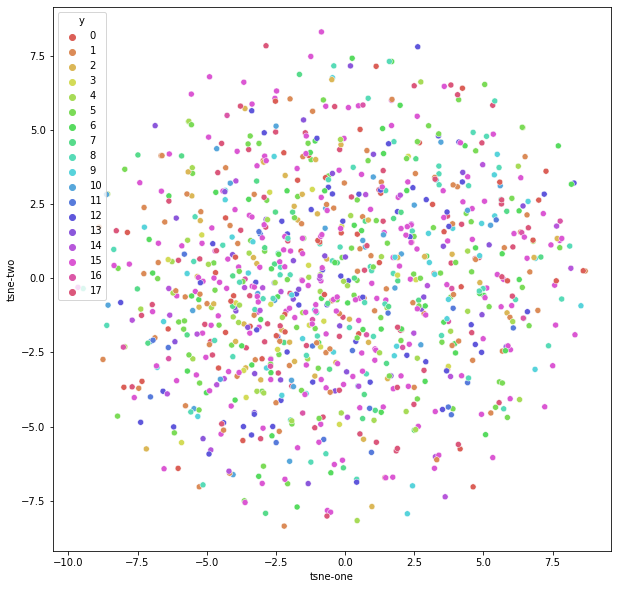

In [19]:
cms_df_subset={}
cms_df_subset['tsne-one'] = x_2d[:,0]
cms_df_subset['tsne-two'] = x_2d[:,1]
cms_df_subset['y'] = np.array(labels)
plt.figure(figsize=(10,10))
# ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    palette=sns.color_palette("hls", 18),
    data=cms_df_subset,
#     legend="full",
    alpha=1,
#     ax=ax1
)